1. Plotting actual vs predicted using all data (fit NN to all data first)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the TensorBoard notebook extension.

%reload_ext tensorboard
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.keras import initializers
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import SGD
from tensorflow.python.keras.optimizer_v2.adam import Adam
from tensorflow.keras.layers import Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from tensorflow.keras import backend as K
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import pathlib
import pickle
from pickle import load , dump
import pathlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from datetime import datetime
import seaborn as sns
import tensorboard
import copy
tensorboard.__version__

'2.6.0'

In [ ]:
MicroclimateData = pd.read_csv('/content/drive/Shareddrives/Microclimate-Building Energy/Data/microclimate_model/Combined/all_buildings_limited.csv')
WeatherStationData = pd.read_csv('/content/drive/Shareddrives/Microclimate-Building Energy/Data/NN_big_data/Combined/all_buildings_big.csv')

In [ ]:
# Function to split same percent for each unique data in df column
def split_unique(dataset, column, test_size):
  X_train2 = pd.DataFrame()
  X_test2 = pd.DataFrame()
  y_train2 = pd.DataFrame()
  y_test2 = pd.DataFrame()
  for i,C in enumerate(dataset[column].unique()):
    X = dataset[dataset[column] == C][['bldgname',
                                    'Air Temp', 
                                    'Abs Hum',
                                    'DSW Top', 
                                    'DSW North', 
                                    'DSW South', 
                                    'DSW East', 
                                    'DSW West', 
                                    'Shade North', 
                                    'Shade East', 
                                    'Shade West',
                                    'Shade South']]
    y = dataset[dataset[column] == C]['CHWTON/SQFT']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=20)
    X_train2 = X_train2.append(X_train)
    X_test2 = X_test2.append(X_test)
    y_train2 = y_train2.append(y_train)
    y_test2 = y_test2.append(y_test)
  return X_train2, X_test2, y_train2, y_test2

# Split microclimate data 20% from each building for testing
X_train2, X_test2, y_train2, y_test2 = split_unique(MicroclimateData, 'bldgname', 0.2)
print(X_train2.shape)
print(y_train2.shape)
print(X_test2.shape)

# Check number of points in each building
# Note: Biodesign C has less data than all other buildings in original data
# for i,C in enumerate(MicroclimateData['bldgname'].unique()):
#   print(C, ":", len(MicroclimateData[MicroclimateData['bldgname']==C]))

(7668, 12)
(11, 7668)
(1921, 12)


## Flow of Code:
#### 1. Read both datasets, and do data preparation: Scaling, One-hot Encoding
#### 2. For limited data, train  model on Temp, Hum, Dsw(4), Shade(4), Encoding input features (find hyperparameters analytically)
#### 3. For big data, train model on Temp, Hum, Encoding 
#### 4. Fine tune weather station model on microclimate data and compare performance
#### 5. Work on adding artificial features and dropout on microclimate model

In [85]:
class NeuralNetwork():
    def __init__(self,activation_type, hidden_layers, loss, kernel_initializer, bias_initializer, data_type,epochs):
        self.activation_type = activation_type
        self.hidden_layers = hidden_layers
        self.loss = loss
        self.kernel_initializer = kernel_initializer
        self.bias_initializer = bias_initializer 
        self.data_type = data_type
        self.epochs = epochs
        self.scaler = StandardScaler()

    def huber_loss(y_true, y_pred, clip_delta=1.0):
        error = y_true - y_pred
        cond  = tf.keras.backend.abs(error) < clip_delta
        squared_loss = 0.5 * tf.keras.backend.square(error)
        linear_loss  = clip_delta * (tf.keras.backend.abs(error) - 0.5 * clip_delta)
        return tf.where(cond, squared_loss, linear_loss)
        
    def huber_loss_mean(y_true, y_pred, clip_delta=1.0):
        return tf.keras.backend.mean(huber_loss(y_true, y_pred, clip_delta))
    # Function to split same percent for each unique data in df column
    def split_unique(dataset, column, data_columns, test_size):
        X_train2 = pd.DataFrame()
        X_test2 = pd.DataFrame()
        y_train2 = pd.DataFrame()
        y_test2 = pd.DataFrame()
        for i,C in enumerate(dataset[column].unique()):
            X = dataset[dataset[column] == C][data_columns]
            y = dataset[dataset[column] == C]['CHWTON/SQFT']
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=20)
            X_train2 = X_train2.append(X_train)
            X_test2 = X_test2.append(X_test)
            y_train2 = y_train2.append(y_train)
            y_test2 = y_test2.append(y_test)
        return X_train2, X_test2, y_train2, y_test2
        
    def prepare_data(self, dataset, func):        
        #add artificial features
        dataset['Air Temp Squared'] =  dataset['Air Temp']**2
        dataset['Abs Hum Squared'] =  dataset['Abs Hum']**2
        dataset['Air Temp*Abs Hum'] =  dataset['Air Temp']* dataset['Abs Hum']
        MicroclimateData['Air Temp Squared'] =  MicroclimateData['Air Temp']**2
        MicroclimateData['Abs Hum Squared'] =  MicroclimateData['Abs Hum']**2
        MicroclimateData['Air Temp*Abs Hum'] =  MicroclimateData['Air Temp']* MicroclimateData['Abs Hum']
        if self.data_type == 'WeatherStation'  and (func == 'test' or func == 'train'):
            X = dataset[['bldgname',
                        'Air Temp', 
                        'Abs Hum',
                        'Air Temp Squared',
                        'Abs Hum Squared',
                        'Air Temp*Abs Hum']]
            columns = ['Air Temp', 'Abs Hum',
                       'Air Temp Squared',
                        'Abs Hum Squared',
                        'Air Temp*Abs Hum']
            Y = dataset['CHWTON/SQFT']
        if self.data_type == 'Microclimate' and func == 'train':
            X = MicroclimateData[['bldgname',
                                  'Air Temp', 
                                  'Abs Hum',
                                  'Air Temp Squared',
                                  'Abs Hum Squared',
                                  'Air Temp*Abs Hum',
                                  'DSW Top', 
                                  'DSW North', 
                                  'DSW South', 
                                  'DSW East', 
                                  'DSW West', 
                                  'Shade North', 
                                  'Shade East', 
                                  'Shade West',
                                  'Shade South']]
            columns = ['Air Temp', 'Abs Hum', 'Air Temp Squared',
                        'Abs Hum Squared', 'Air Temp*Abs Hum', 'DSW Top',
                       'DSW North', 'DSW South', 'DSW East','DSW West',
                       'Shade North', 'Shade East', 'Shade West', 'Shade South',]
            Y = MicroclimateData['CHWTON/SQFT']
        if self.data_type == 'Microclimate' and func == 'test':
            X = MicroclimateData[['bldgname',
                        'Air Temp', 
                        'Abs Hum',
                        'Air Temp Squared',
                        'Abs Hum Squared',
                        'Air Temp*Abs Hum']]
            columns = ['Air Temp', 'Abs Hum',
                       'Air Temp Squared',
                        'Abs Hum Squared',
                        'Air Temp*Abs Hum']
            Y = MicroclimateData['CHWTON/SQFT']
        Y = Y.values.reshape(-1, 1)
        Y = self.scaler.fit_transform(Y)
        X = pd.get_dummies(X)
        StdSc2 = StandardScaler()
        X[columns] = StdSc2.fit_transform(X[columns])
#         X_train, X_test, y_train, y_test = self.split_unique(X, 'bldgname', columns, 0.2)
        X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                                            test_size=0.2, 
                                                            random_state=20)
        return X_train, X_test, y_train, y_test
    def define_model(self):
        if self.data_type == 'WeatherStation' :
            model = Sequential()
            if self.activation_type == 'leaky_relu':
                model.add(Dense(20, 
                                input_dim=16, 
                                kernel_initializer=self.kernel_initializer, 
                                bias_initializer=self.bias_initializer, 
                                activation= self.activation_type))
                for i in range(0,(self.hidden_layers-2)):
                    model.add(Dense(30, activation = self.activation_type))
                model.add(Dense(50, activation = self.activation_type))
                model.add(Dropout(0.05))
                model.add(Dense(1, activation = 'linear'))
            else:
                model.add(Dense(30, 
                                input_dim=16, 
                                kernel_initializer=self.kernel_initializer, 
                                bias_initializer=self.bias_initializer, 
                                activation= self.activation_type))
                for i in range(0,(self.hidden_layers-2)):
                    model.add(Dense(40, activation = self.activation_type))
                model.add(Dense(50, activation = self.activation_type))
                model.add(Dropout(0.05))
                model.add(Dense(1, activation = 'linear'))           
        if self.data_type == 'Microclimate':
            model = Sequential()
            if self.activation_type == 'leaky_relu':
                model.add(Dense(30, 
                                input_dim=25, 
                                kernel_initializer=self.kernel_initializer, 
                                bias_initializer=self.bias_initializer, 
                                activation= self.activation_type))
                for i in range(0,(self.hidden_layers-2)):
                    model.add(Dense(40, activation = self.activation_type))
                model.add(Dense(50, activation = self.activation_type))
                model.add(Dropout(0.05))
                model.add(Dense(1, activation = 'linear'))
            else:
                model.add(Dense(30, 
                                input_dim=25, 
                                kernel_initializer=self.kernel_initializer, 
                                bias_initializer=self.bias_initializer, 
                                activation= self.activation_type))
                for i in range(0,(self.hidden_layers-2)):
                    model.add(Dense(40, activation = self.activation_type))
                model.add(Dense(50, activation = self.activation_type))
                model.add(Dropout(0.05))
                model.add(Dense(1, activation = 'linear'))
        model.compile( loss = self.loss, 
                      optimizer = 'adam')
        model.summary()
        return model
    def train(self, dataset):
        X_train, X_test, y_train, y_test = self.prepare_data(dataset,'train')
        self.model = self.define_model()
        # Define the Keras TensorBoard callback.
        logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
        self.history = self.model.fit(X_train,y_train, 
                            batch_size=128, 
                            epochs=self.epochs, 
                            verbose=0, 
                            validation_split=0.2, 
                            shuffle = True ,
                            callbacks=[tensorboard_callback])
    def fine_tune(self, dataset,alpha=0.001):
        self.model.trainable = True
        fine_tune_at = 2
        for layer in self.model.layers[:fine_tune_at]:
            layer.trainable =  False
        opt = Adam(learning_rate = alpha)    
        self.model.compile(loss=self.loss, 
                           optimizer=opt)
        X_train, X_test, y_train, y_test = self.prepare_data(dataset,'test')
        # Define the Keras TensorBoard callback.
        logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
        self.history = self.model.fit(X_train,y_train, 
                            batch_size=128, 
                            epochs=self.epochs, 
                            verbose=0, 
                            validation_split=0.2, 
                            shuffle = True ,
                            callbacks=[tensorboard_callback])
        
        
    def plot_curve(self):
        plt.plot(self.history.history['loss'])
        plt.plot(self.history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.show()
    def evaluate(self, dataset, data_type ):
        call_type = 'test'
        if data_type == self.data_type:
            call_type = 'train'
        _, X_test, _, y_test = self.prepare_data(dataset,call_type)
        Y_preds = self.model.predict(X_test)
        RMSE = np.sqrt(metrics.mean_squared_error(y_test, Y_preds))
        R2_score = metrics.r2_score(y_test, Y_preds)
        print("The RMSE score for test dataset of "+ data_type +" on model type:" + self.data_type + " model " +" is:", RMSE) 
        print("The R2 score for test dataset of "+ data_type +" on model type:" + self.data_type + " model " +" is:", R2_score)
        return Y_preds, y_test, X_test 

## Hyperparameter Tuning


In [ ]:
# eval_func = []
# max_R2 = -inf
# for func in activation_functions:
#     eval_func_layers = []
#     for hl in no_hidden_layers:
#         eval_func_loss = []
#         for loss in loss_functions:
#             model = define_model(func,hl,loss)
#             history = model.fit(X_train, Y_train, batch_size=128, epochs=150,  validation_split=0.2, verbose=0)
#             RMSE, R2 = evaluate(base_model, X_test, Y_test)
#             RMSE_base_model, R2_base_model = evaluate(base_model, X_limited_test,Y_limited_test)
#             eval_func_loss.append(R2)
#         eval_func_layers.append(eval_func_loss)
#     eval_func.append(eval_func_layers)
# print(eval_func)   
# tab = pd.DataFrame(eval_func, activation_functions, no_hidden_layers_headings,loss_functions_headings)
# print(tab)

def tune_multiple_buildings():
    activation_functions = ['relu','elu','selu','leaky_relu']
    no_hidden_layers = [3,4,5]
    loss_functions = ['mean_squared_error','mean_absolute_error','huber_loss']
#     loss_functions_headings = ['mean_squared_error','mean_absolute_error','mean_absolute_percentage_error','huber_loss']
    ### Create dataframe and add building names ###
    rf_optimal_model = pd.DataFrame(columns = {"bldgname", "R2_score_bigdata_best","R2_score_limiteddata_best", 'Activation Function','No of hidden layers', 'Loss function' })

    for i in list(MicroclimateData['bldgname'].unique()):
        rf_optimal_model = rf_optimal_model.append({'bldgname': i}, ignore_index=True)
    rf_optimal_model.fillna(5)
    ### Train over all hyperparameters over all buildings ###
    Buildings = list(MicroclimateData['bldgname'].unique())
    for i in range(len(Buildings)):
        max = 0
        # drop na values if in dataframe
        building_name = Buildings[i]
        print("Find parameters for "+ building_name)
        optimal_hyperparameters=[]
        # Limited Data
        NN = NeuralNetwork('relu',4, 'huber_loss', 'he_normal','he_normal', 'Microclimate', 250)
        X_limited_train, X_limited_test, Y_limited_train,Y_limited_test = NN.prepare_data(MicroclimateData.loc[MicroclimateData['bldgname'] == Buildings[i]],'train')
        for func in activation_functions:
            for hl in no_hidden_layers:
                for loss in loss_functions:
                    print("Results for hyperparameters:Activation Fn: "+ func+ " #hidden_layers: "+ str(hl) + " loss function: "+ str(loss))
                    Testmodel = NeuralNetwork( func, hl, loss, 'he_normal','he_normal', 'Microclimate', 250)
                    Testmodel.model = Testmodel.define_model()
                    history = Testmodel.model.fit(X_limited_train, Y_limited_train, batch_size=128, epochs=150,  validation_split=0.2, verbose=0)
                    Y_preds = Testmodel.model.predict(X_limited_test)
                    R2_base_model = metrics.r2_score(Y_limited_test, Y_preds) 
                    print("The R2 score for test dataset on Microclimate Data model " +" is:", R2_base_model)
                    if(R2_base_model>max):
                        max = R2_base_model
                        print("Updated hyperparameters for building: "+ building_name +"max_R2:"+str(max)+": Activation Fn: "+ str(func)+ " #hidden_layers: "+ str(hl) + " loss function: "+ str(loss))
                        rf_optimal_model["R2_score_limiteddata_best"][i]=R2_base_model
                        rf_optimal_model["Activation Function"][i]=func
                        rf_optimal_model["No of hidden layers"][i]=hl
                        rf_optimal_model["Loss function"][i]=loss
    rf_optimal_model = rf_optimal_model[["bldgname","R2_score_limiteddata_best", 'Activation Function','No of hidden layers', 'Loss function']]
    return rf_optimal_model
optimal_model_buildings = tune_multiple_buildings()
display(optimal_model_buildings)


Find parameters for Noble Library
Results for hyperparameters:Activation Fn: relu #hidden_layers: 3 loss function: mean_squared_error
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_67 (Dense)             (None, 30)                780       
_________________________________________________________________
dense_68 (Dense)             (None, 40)                1240      
_________________________________________________________________
dense_69 (Dense)             (None, 50)                2050      
_________________________________________________________________
module_wrapper_15 (ModuleWra (None, 50)                0         
_________________________________________________________________
dense_70 (Dense)             (None, 1)                 51        
Total params: 4,121
Trainable params: 4,121
Non-trainable params: 0
_________________________________________________

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

The R2 score for test dataset on Microclimate Data model  is: 0.9796825995152645
Updated hyperparameters for building: Noble Librarymax_R2:0.9796825995152645: Activation Fn: relu #hidden_layers: 3 loss function: mean_squared_error
Results for hyperparameters:Activation Fn: relu #hidden_layers: 3 loss function: mean_absolute_error
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_71 (Dense)             (None, 30)                780       
_________________________________________________________________
dense_72 (Dense)             (None, 40)                1240      
_________________________________________________________________
dense_73 (Dense)             (None, 50)                2050      
_________________________________________________________________
module_wrapper_16 (ModuleWra (None, 50)                0         
___________________________________________________

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

The R2 score for test dataset on Microclimate Data model  is: 0.9775355650617088
Updated hyperparameters for building: Biodesign Cmax_R2:0.9775355650617088: Activation Fn: relu #hidden_layers: 3 loss function: mean_squared_error
Results for hyperparameters:Activation Fn: relu #hidden_layers: 3 loss function: mean_absolute_error
Model: "sequential_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_251 (Dense)            (None, 30)                780       
_________________________________________________________________
dense_252 (Dense)            (None, 40)                1240      
_________________________________________________________________
dense_253 (Dense)            (None, 50)                2050      
_________________________________________________________________
module_wrapper_52 (ModuleWra (None, 50)                0         
_____________________________________________________

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

The R2 score for test dataset on Microclimate Data model  is: 0.9753369378466027
Updated hyperparameters for building: Biodesign Amax_R2:0.9753369378466027: Activation Fn: relu #hidden_layers: 3 loss function: mean_squared_error
Results for hyperparameters:Activation Fn: relu #hidden_layers: 3 loss function: mean_absolute_error
Model: "sequential_88"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_431 (Dense)            (None, 30)                780       
_________________________________________________________________
dense_432 (Dense)            (None, 40)                1240      
_________________________________________________________________
dense_433 (Dense)            (None, 50)                2050      
_________________________________________________________________
module_wrapper_88 (ModuleWra (None, 50)                0         
_____________________________________________________

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

The R2 score for test dataset on Microclimate Data model  is: 0.9792123226852668
Updated hyperparameters for building: Schwada COBmax_R2:0.9792123226852668: Activation Fn: relu #hidden_layers: 3 loss function: mean_squared_error
Results for hyperparameters:Activation Fn: relu #hidden_layers: 3 loss function: mean_absolute_error
Model: "sequential_124"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_611 (Dense)            (None, 30)                780       
_________________________________________________________________
dense_612 (Dense)            (None, 40)                1240      
_________________________________________________________________
dense_613 (Dense)            (None, 50)                2050      
_________________________________________________________________
module_wrapper_124 (ModuleWr (None, 50)                0         
____________________________________________________

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

The R2 score for test dataset on Microclimate Data model  is: 0.9780864418668338
Updated hyperparameters for building: Psychologymax_R2:0.9780864418668338: Activation Fn: relu #hidden_layers: 3 loss function: mean_squared_error
Results for hyperparameters:Activation Fn: relu #hidden_layers: 3 loss function: mean_absolute_error
Model: "sequential_160"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_791 (Dense)            (None, 30)                780       
_________________________________________________________________
dense_792 (Dense)            (None, 40)                1240      
_________________________________________________________________
dense_793 (Dense)            (None, 50)                2050      
_________________________________________________________________
module_wrapper_160 (ModuleWr (None, 50)                0         
_____________________________________________________

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

The R2 score for test dataset on Microclimate Data model  is: 0.9786502059254032
Updated hyperparameters for building: Goldwatermax_R2:0.9786502059254032: Activation Fn: relu #hidden_layers: 3 loss function: mean_squared_error
Results for hyperparameters:Activation Fn: relu #hidden_layers: 3 loss function: mean_absolute_error
Model: "sequential_196"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_971 (Dense)            (None, 30)                780       
_________________________________________________________________
dense_972 (Dense)            (None, 40)                1240      
_________________________________________________________________
dense_973 (Dense)            (None, 50)                2050      
_________________________________________________________________
module_wrapper_196 (ModuleWr (None, 50)                0         
______________________________________________________

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

The R2 score for test dataset on Microclimate Data model  is: 0.9788521743365904
Updated hyperparameters for building: ISTB 2max_R2:0.9788521743365904: Activation Fn: relu #hidden_layers: 3 loss function: mean_squared_error
Results for hyperparameters:Activation Fn: relu #hidden_layers: 3 loss function: mean_absolute_error
Model: "sequential_232"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1151 (Dense)           (None, 30)                780       
_________________________________________________________________
dense_1152 (Dense)           (None, 40)                1240      
_________________________________________________________________
dense_1153 (Dense)           (None, 50)                2050      
_________________________________________________________________
module_wrapper_232 (ModuleWr (None, 50)                0         
_________________________________________________________

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

The R2 score for test dataset on Microclimate Data model  is: 0.9802625842248192
Updated hyperparameters for building: Bulldog Hallmax_R2:0.9802625842248192: Activation Fn: relu #hidden_layers: 3 loss function: mean_squared_error
Results for hyperparameters:Activation Fn: relu #hidden_layers: 3 loss function: mean_absolute_error
Model: "sequential_268"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1331 (Dense)           (None, 30)                780       
_________________________________________________________________
dense_1332 (Dense)           (None, 40)                1240      
_________________________________________________________________
dense_1333 (Dense)           (None, 50)                2050      
_________________________________________________________________
module_wrapper_268 (ModuleWr (None, 50)                0         
___________________________________________________

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

The R2 score for test dataset on Microclimate Data model  is: 0.9788244499912413
Updated hyperparameters for building: ISTB 4max_R2:0.9788244499912413: Activation Fn: relu #hidden_layers: 3 loss function: mean_squared_error
Results for hyperparameters:Activation Fn: relu #hidden_layers: 3 loss function: mean_absolute_error
Model: "sequential_304"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1511 (Dense)           (None, 30)                780       
_________________________________________________________________
dense_1512 (Dense)           (None, 40)                1240      
_________________________________________________________________
dense_1513 (Dense)           (None, 50)                2050      
_________________________________________________________________
module_wrapper_304 (ModuleWr (None, 50)                0         
_________________________________________________________

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

The R2 score for test dataset on Microclimate Data model  is: 0.9781520924389552
Updated hyperparameters for building: Psychology Northmax_R2:0.9781520924389552: Activation Fn: relu #hidden_layers: 3 loss function: mean_squared_error
Results for hyperparameters:Activation Fn: relu #hidden_layers: 3 loss function: mean_absolute_error
Model: "sequential_340"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1691 (Dense)           (None, 30)                780       
_________________________________________________________________
dense_1692 (Dense)           (None, 40)                1240      
_________________________________________________________________
dense_1693 (Dense)           (None, 50)                2050      
_________________________________________________________________
module_wrapper_340 (ModuleWr (None, 50)                0         
_______________________________________________

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

The R2 score for test dataset on Microclimate Data model  is: 0.9774529623989523
Updated hyperparameters for building: Biodesign Bmax_R2:0.9774529623989523: Activation Fn: relu #hidden_layers: 3 loss function: mean_squared_error
Results for hyperparameters:Activation Fn: relu #hidden_layers: 3 loss function: mean_absolute_error
Model: "sequential_376"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1871 (Dense)           (None, 30)                780       
_________________________________________________________________
dense_1872 (Dense)           (None, 40)                1240      
_________________________________________________________________
dense_1873 (Dense)           (None, 50)                2050      
_________________________________________________________________
module_wrapper_376 (ModuleWr (None, 50)                0         
____________________________________________________

,bldgname,R2_score_limiteddata_best,Activation Function,No of hidden layers,Loss function
0,Noble Library,0.981386,relu,5,huber_loss
1,Biodesign C,0.982189,relu,5,mean_squared_error
2,Biodesign A,0.981596,relu,5,mean_squared_error
3,Schwada COB,0.981809,leaky_relu,5,huber_loss
4,Psychology,0.983313,leaky_relu,5,mean_squared_error
5,Goldwater,0.982103,relu,5,mean_squared_error
6,ISTB 2,0.98255,relu,5,mean_squared_error
7,Bulldog Hall,0.983328,relu,5,huber_loss
8,ISTB 4,0.982887,relu,4,huber_loss
9,Psychology North,0.981532,relu,5,huber_loss


In [ ]:
# Tune for combined dataset
def tune_combined():
    activation_functions = ['relu','elu','selu','leaky_relu']
    no_hidden_layers = [3,4,5]
    loss_functions = ['mean_squared_error','mean_absolute_error','huber_loss']
    rf_combined = pd.DataFrame(columns = {'Activation Function','No of hidden layers', 'Loss function' ,'R2_score_best','RMSE_score_best'})
    NN = NeuralNetwork('relu',4, 'huber_loss', 'he_normal','he_normal', 'Microclimate', 250)
    X_limited_train, X_limited_test, Y_limited_train,Y_limited_test = NN.prepare_data(MicroclimateData,'train')
    
    for i in range(len(activation_functions)):
        rf_combined = rf_combined.append({'Activation Function': activation_functions[i]}, ignore_index=True)
    rf_combined.fillna(5)  

    
    for i in range(len(activation_functions)):
        R2_max = 0
        func = activation_functions[i]
        for hl in no_hidden_layers:
            for loss in loss_functions:
                print("Results for hyperparameters:Activation Fn: "+ func+ " #hidden_layers: "+ str(hl) + " loss function: "+ str(loss))
                Testmodel = NeuralNetwork( func, hl, loss, 'he_normal','he_normal', 'Microclimate', 250)
                Testmodel.model = Testmodel.define_model()
                history = Testmodel.model.fit(X_limited_train, Y_limited_train, batch_size=128, epochs=150,  validation_split=0.2, verbose=0)
                Y_preds = Testmodel.model.predict(X_limited_test)
                R2_base = metrics.r2_score(Y_limited_test, Y_preds)
                RMSE_base = np.sqrt(metrics.mean_squared_error(Y_limited_test, Y_preds))
                if(R2_base>R2_max):
                    R2_max = R2_base
                    rf_combined["Activation Function"][i]=func
                    rf_combined["No of hidden layers"][i]=hl
                    rf_combined["Loss function"][i]=loss
                    rf_combined["R2_score_best"][i]=R2_base
                    rf_combined["RMSE_score_best"][i]=RMSE_base
        rf_combined = rf_combined[['Activation Function','No of hidden layers', 'Loss function', 'R2_score_best','RMSE_score_best']]
    return rf_combined
best_hyperparameters = tune_combined()   
display(best_hyperparameters)                 

Results for hyperparameters:Activation Fn: relu #hidden_layers: 3 loss function: mean_squared_error
Model: "sequential_495"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2462 (Dense)           (None, 30)                780       
_________________________________________________________________
dense_2463 (Dense)           (None, 40)                1240      
_________________________________________________________________
dense_2464 (Dense)           (None, 50)                2050      
_________________________________________________________________
module_wrapper_495 (ModuleWr (None, 50)                0         
_________________________________________________________________
dense_2465 (Dense)           (None, 1)                 51        
Total params: 4,121
Trainable params: 4,121
Non-trainable params: 0
_________________________________________________________________
Results for hype

,Activation Function,No of hidden layers,Loss function,R2_score_best,RMSE_score_best
0,relu,5,mean_squared_error,0.982585,0.129902
1,elu,5,mean_squared_error,0.976729,0.150162
2,selu,5,mean_squared_error,0.977092,0.148988
3,leaky_relu,5,huber_loss,0.981738,0.133024


In [86]:
max_value = best_hyperparameters['R2_score_best'].max()
max_index = max(best_hyperparameters.index[best_hyperparameters['R2_score_best']==max_value])

number_layers = best_hyperparameters['No of hidden layers'][max_index]
loss_func = best_hyperparameters['Loss function'][max_index]
act_func = best_hyperparameters['Activation Function'][max_index]

#Training the 2 models:

In [87]:
if __name__ == "__main__":
    # Train microclimate Model
    MicroclimateModel = NeuralNetwork(act_func, number_layers, loss_func, 'he_normal','he_normal', 'Microclimate', 250)
    MicroclimateModel.train(MicroclimateData)
    Y_preds_NN, y_test_NN, X_test_NN = MicroclimateModel.evaluate(MicroclimateData, 'Microclimate')
    # Train Weather Station Model
    WeatherStationModel = NeuralNetwork('relu',5, 'huber_loss', 'he_normal','he_normal', 'WeatherStation', 100)
    WeatherStationModel.train(WeatherStationData)
    tempModel = NeuralNetwork('relu',4, 'huber_loss', 'he_normal','he_normal', 'WeatherStation', 100)
    tempModel.train(WeatherStationData)
    _,_,_ = WeatherStationModel.evaluate(WeatherStationData, 'WeatherStation')
   


Model: "sequential_534"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2659 (Dense)           (None, 30)                780       
_________________________________________________________________
dense_2660 (Dense)           (None, 40)                1240      
_________________________________________________________________
dense_2661 (Dense)           (None, 40)                1640      
_________________________________________________________________
dense_2662 (Dense)           (None, 40)                1640      
_________________________________________________________________
dense_2663 (Dense)           (None, 50)                2050      
_________________________________________________________________
module_wrapper_534 (ModuleWr (None, 50)                0         
_________________________________________________________________
dense_2664 (Dense)           (None, 1)              

##Parameter Tuning:

In [88]:
 
 def ParameterTuning():
  l_rates = [0.001,0.00125,0.0015,0.00175,0.002,0.003,0.01]
  R2_max=0
  lr=0
  for a in l_rates:
    print("Learning rate: "+str(a))
    tempModel.fine_tune(MicroclimateData,alpha=a)   
    Y_preds, y_test, X_test = tempModel.evaluate(MicroclimateData, 'Microclimate')
    RMSE_fine_tune = np.sqrt(metrics.mean_squared_error(y_test, Y_preds))
    R2_fine_tune = metrics.r2_score(y_test, Y_preds)
    if R2_fine_tune>R2_max:
      lr=a
      R2_max=R2_fine_tune
  print(lr)  
  return lr


In [89]:
 # Fine Tune and compare results
learning_rate = ParameterTuning()
WeatherStationModel.fine_tune(MicroclimateData,learning_rate)
Y_preds_TL, y_test_TL, X_test_TL = WeatherStationModel.evaluate(MicroclimateData, 'Microclimate')
_,_,_ = WeatherStationModel.evaluate(WeatherStationData, 'WeatherStation')

Learning rate: 0.001
The RMSE score for test dataset of Microclimate on model type:WeatherStation model  is: 0.15015797780530615
The R2 score for test dataset of Microclimate on model type:WeatherStation model  is: 0.9767306036112837
Learning rate: 0.00125
The RMSE score for test dataset of Microclimate on model type:WeatherStation model  is: 0.14510673842873698
The R2 score for test dataset of Microclimate on model type:WeatherStation model  is: 0.978269813335197
Learning rate: 0.0015
The RMSE score for test dataset of Microclimate on model type:WeatherStation model  is: 0.14333175372887866
The R2 score for test dataset of Microclimate on model type:WeatherStation model  is: 0.978798180871769
Learning rate: 0.00175
The RMSE score for test dataset of Microclimate on model type:WeatherStation model  is: 0.14210080561208843
The R2 score for test dataset of Microclimate on model type:WeatherStation model  is: 0.9791607840077278
Learning rate: 0.002
The RMSE score for test dataset of Micro

##Generating dataframe for scores

In [95]:
R2_NN = metrics.r2_score(y_test_NN, Y_preds_NN)
RMSE_NN = np.sqrt(metrics.mean_squared_error(y_test_NN, Y_preds_NN))
R2_TL = metrics.r2_score(y_test_TL, Y_preds_TL)
RMSE_TL = np.sqrt(metrics.mean_squared_error(y_test_TL, Y_preds_TL))


scores = { 'Model Name':['Microclimate Model','Weather Station Model'],
                                    'R2_score':[R2_NN , R2_TL],
                                    'RMSE_score':[RMSE_NN , RMSE_TL]}
rf_scores = pd.DataFrame(scores)                                    
display(rf_scores)

,Model Name,R2_score,RMSE_score
0,Microclimate Model,0.984111,0.124079
1,Weather Station Model,0.977483,0.147710


## Plotting

Use this to return dummy variables to original columns example: df2 = undummify(df2) 

In [90]:
def undummify(df, prefix_sep="_"):
    cols2collapse = {
        item.split(prefix_sep)[0]: (prefix_sep in item) for item in df.columns
    }
    series_list = []
    for col, needs_to_collapse in cols2collapse.items():
        if needs_to_collapse:
            undummified = (
                df.filter(like=col)
                .idxmax(axis=1)
                .apply(lambda x: x.split(prefix_sep, maxsplit=1)[1])
                .rename(col)
            )
            series_list.append(undummified)
        else:
            series_list.append(df[col])
    undummified_df = pd.concat(series_list, axis=1)
    return undummified_df

0 Psychology
1 Goldwater
2 Schwada COB
3 Bulldog Hall
4 ISTB 4
5 Psychology North
6 Biodesign C
7 Biodesign A
8 Biodesign B
9 Noble Library
10 ISTB 2
[5 6 7 8 9]
Enter the month from the list above: 6
[ 1  3  7  8 11 16 20 21 23 25 26 27 29]
Enter the day from the list above: 25


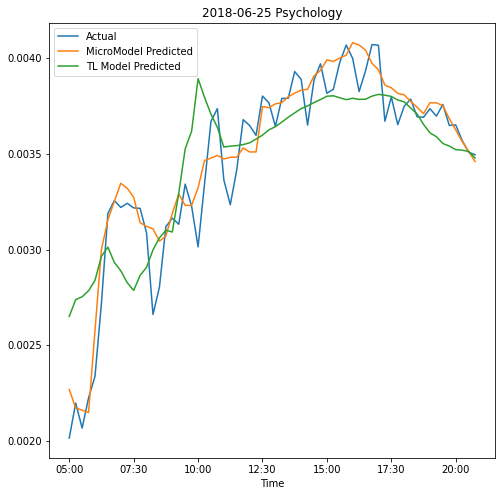

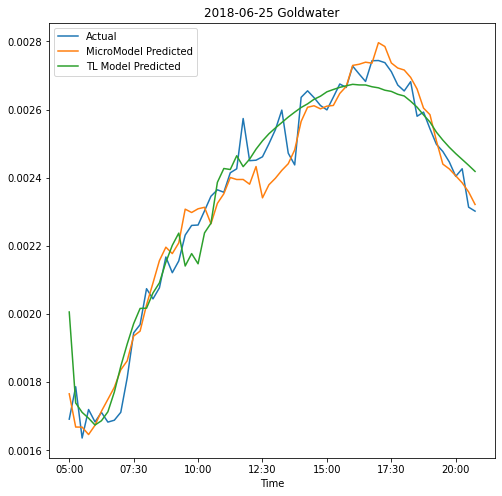

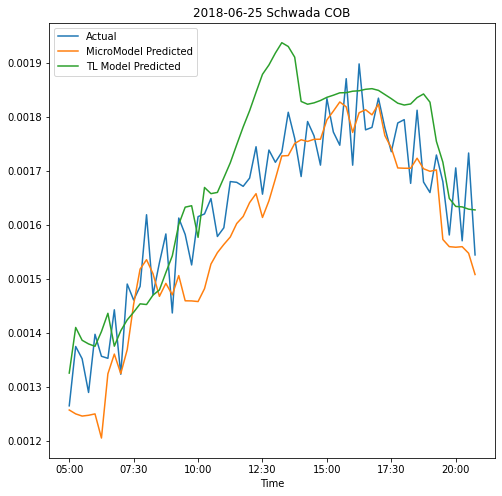

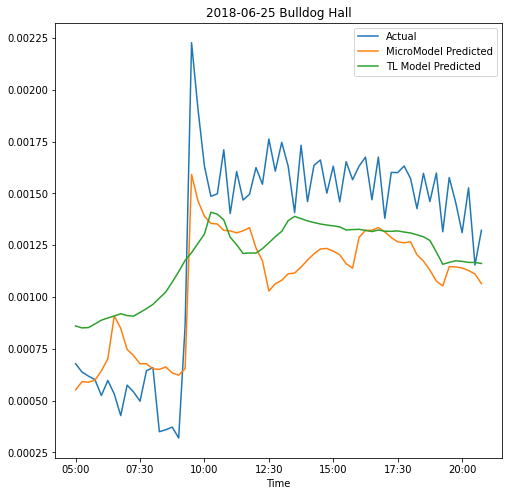

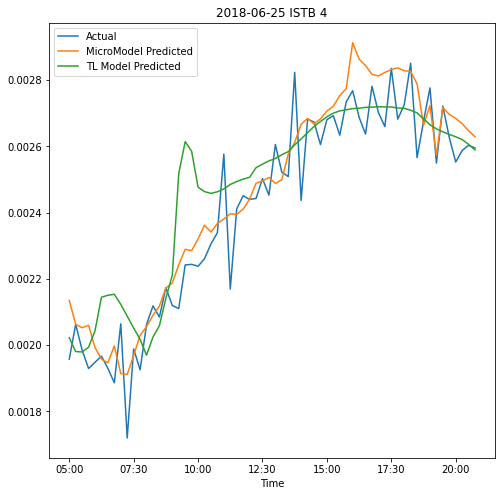

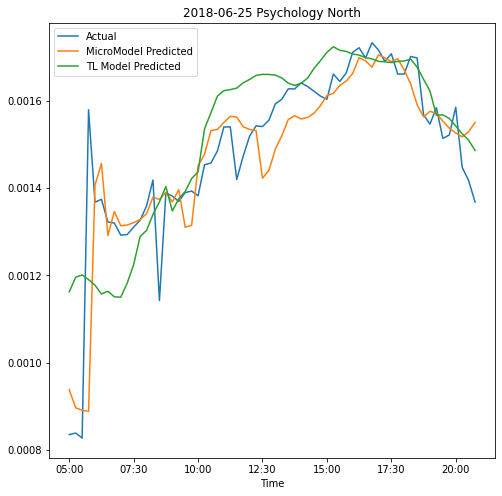

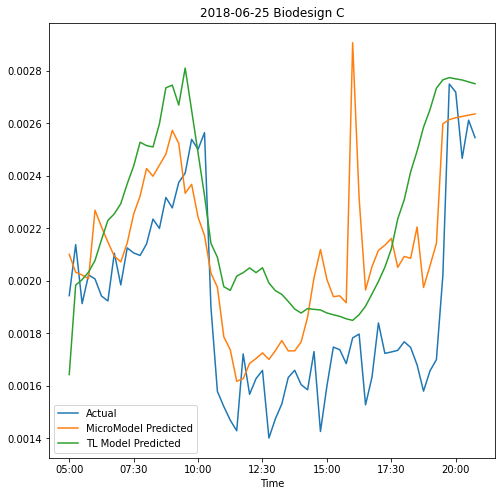

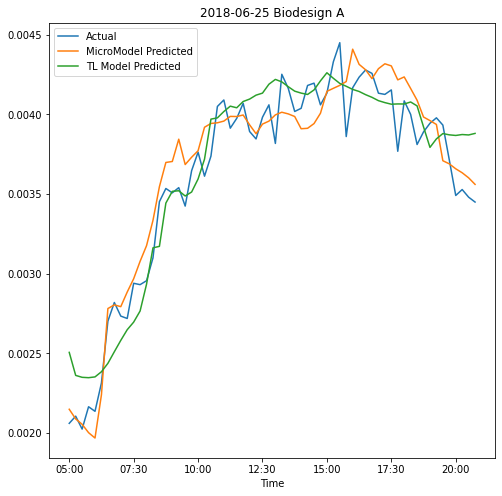

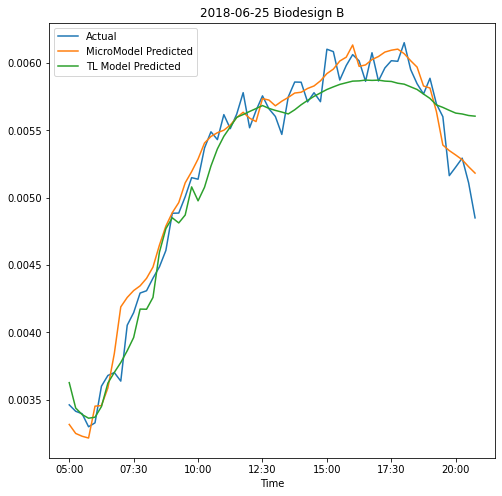

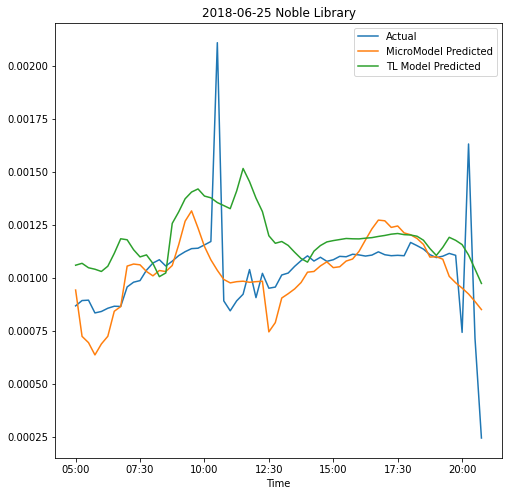

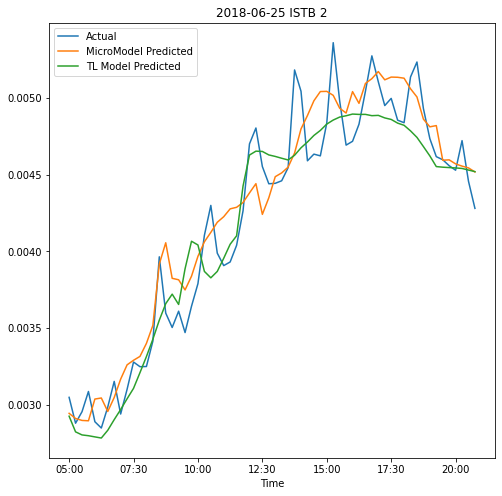

In [83]:
date_time = MicroclimateData[['Date_Time',
                        'Month',
                        'Day',
                        'Hour',
                        'Minute']]

x1,x2,y1,y2 = MicroclimateModel.prepare_data(MicroclimateData,'train')

# Microclimate Model(NN)
comb1 = [x1,x2]
x1 = pd.concat(comb1)
Y_preds_NN = MicroclimateModel.model.predict(x1)
results_NN = undummify(x1).join(date_time)
col = results_NN.pop('bldgname')
results_NN.insert(0, 'bldgname', col)
y1= np.concatenate((y1,y2))
results_NN['Actual'] = MicroclimateModel.scaler.inverse_transform(y1)
results_NN['Time'] = results_NN['Date_Time'].str[11:16]
results_NN['Predicted'] = MicroclimateModel.scaler.inverse_transform(Y_preds_NN)

x3,x4,y3,y4 = WeatherStationModel.prepare_data(MicroclimateData,'test')

#Transfer Learning Model(TL)
comb2 = [x3,x4]
x3 = pd.concat(comb2)
Y_preds_TL = WeatherStationModel.model.predict(x3)
results_TL = undummify(x3).join(date_time)
col = results_TL.pop('bldgname')
results_TL.insert(0, 'bldgname', col)
y3= np.concatenate((y3,y4))
results_TL['Actual'] = WeatherStationModel.scaler.inverse_transform(y3)
results_TL['Time'] = results_NN['Date_Time'].str[11:16]
results_TL['Predicted'] = WeatherStationModel.scaler.inverse_transform(Y_preds_TL)


# User input Building name
Buildings = results_NN['bldgname'].unique()
for i in range(len(Buildings)):
    print(i, Buildings[i])

# User input Month
print(np.sort(results_NN['Month'].unique()))

mnth_num = int(input("Enter the month from the list above: "))

month_NN = results_NN.loc[results_NN['Month'] == mnth_num]
month_TL = results_TL.loc[results_TL['Month'] == mnth_num]

# User input Day
print(np.sort(results_NN['Day'].unique()))
day_num = int(input("Enter the day from the list above: "))
day_NN = month_NN.loc[month_NN['Day'] == day_num]
day_TL = month_TL.loc[month_TL['Day'] == day_num]

for bldg in Buildings:
  bldg_NN = day_NN.loc[results_NN['bldgname']==bldg]
  bldg_TL = day_TL.loc[results_TL['bldgname']==bldg]

  if len(bldg_NN) == 0 and len(bldg_TL)==0:
      print("Not any value for this date")
      break

  values_NN = bldg_NN.sort_values(by=['Time'])
  values_TL = bldg_TL.sort_values(by=['Time'])
  values_NN['MicroModel Predicted'] = values_NN['Predicted']
  values_TL['TL Model Predicted'] = values_TL['Predicted']


  ax = values_NN.plot(x='Time',y='Actual',grid = False, figsize = (8,8))
  values_NN.plot(x='Time',y='MicroModel Predicted',grid = False, figsize = (8,8),ax=ax)
  values_TL.plot(x='Time',y='TL Model Predicted',grid = False, figsize = (8,8),ax=ax)
  ind = values_NN.index
  ax.title.set_text(values_NN['Date_Time'][ind[0]][0:10] +' '+ bldg)
  

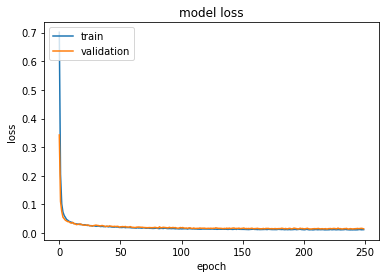

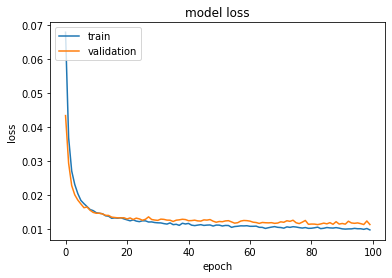

In [96]:
MicroclimateModel.plot_curve()
WeatherStationModel.plot_curve()